In [1]:
import argparse, os, sys, glob
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import PIL.Image
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
# from imwatermark import WatermarkEncoder
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from torch.utils.data import DataLoader
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config, default
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from ldm.models.diffusion.dpm_solver import DPMSolverSampler
from ldm.data.synapse import SynapseValidation, SynapseValidationVolume, SynapseValidationVolume4test
from ldm.data.refuge2 import REFUGE2Validation, REFUGE2Test
from pytorch_lightning.utilities.distributed import rank_zero_only
from scipy.ndimage import zoom
from ldm.data.synapse import COLOR_MAP, quantize_mapping, decolorize, SynapseValidationVolume, colorize

# from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
# from transformers import AutoFeatureExtractor

/GPUFS/nsccgz_ywang_zfd/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-11 23:58:32.014628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 23:58:34.218734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
@rank_zero_only
def save_dice_hist(dice_list, outpath, pl_sd):
    plt.style.use("seaborn")
    plt.hist(dice_list, bins=100)
    plt.xlabel(f"dice score (avg: {sum(dice_list) / len(dice_list)})")
    plt.ylabel("number of samples")
    plt.title(f"{pl_sd['global_step']}")
    plt.xlim(0, 1)
    plt.savefig(os.path.join(outpath, f"dices_{pl_sd['global_step']}.png"))
    plt.clf()
    print('[saving figure]: {}'.format(os.path.join(outpath, f"dices_{pl_sd['global_step']}.png")))

def save_fig(img, path):
    Image.fromarray(img).save(path)

def prepare_for_first_stage(x, gpu=True):
    x = x.clone().detach()
    if len(x.shape) == 3:
        x = x[None, ...]
    x = rearrange(x, 'b h w c -> b c h w')
    if gpu:
        x = x.to(memory_format=torch.contiguous_format).float().cuda()
    else:
        x = x.float()
    return x

def dice_score(pred, targs):
    pred[pred > 0] = 1
    targs[targs > 0] = 1
    # if targs is None:
    #     return None
    # pred = (pred > 0.5).astype(np.float32)
    # targs = (targs > 0.5).astype(np.float32)
    if pred.sum() > 0 and targs.sum() == 0:
        return 1
    elif pred.sum() > 0 and targs.sum() > 0:
        # intersection = (pred * targs).sum()
        # union = pred.sum() + targs.sum() - intersection
        # return (2. * intersection) / (union + 10e-6)
        return (2. * (pred * targs).sum()) / (pred.sum() + targs.sum() + 1e-10)
    else:
        return 0

def intersection_union(pred, targs):
    pred = (pred > 0.5).astype(np.float32)
    targs = (targs > 0.5).astype(np.float32)
    intersection = (pred * targs).sum()
    union = pred.sum() + targs.sum() - intersection
    return intersection, union

def load_model_from_config(config, ckpt):
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    print(set(key.split(".")[0] for key in sd.keys()))
    print(f"\033[31m[Model Weights Rewrite]: Loading model from {ckpt}\033[0m")
    m, u = model.load_state_dict(sd, strict=False)
    # if len(m) > 0 and verbose:
    print("\033[31mmissing keys:\033[0m")
    print(m)
    # if len(u) > 0 and verbose:
    print("\033[31munexpected keys:\033[0m")
    print(u)
    # model.cuda()
    model.eval()
    return model, pl_sd

def calculate_volume_dice(**kwargs):
    # inter_list, union_list, pred_sum, gt_sum = kwargs
    inter = sum(kwargs["inter_list"])
    union = sum(kwargs["union_list"])
    if kwargs["pred_sum"] > 0 and kwargs["gt_sum"] > 0:
        return 2 * inter / (union + 1e-10)
    elif kwargs["pred_sum"] > 0 and kwargs["gt_sum"] == 0:
        return 1
    else:
        return 0

In [3]:
os.getcwd()

'/GPUFS/nsccgz_ywang_zfd/LinTianyu/Internship/stable-diffusion/scripts'

In [3]:
parser = argparse.ArgumentParser()
# dataset settings
parser.add_argument("--dataset", type=str,  # '-b' for binary, '-m' for multi
                    choices=["synapse-b", "synapse-m", "refuge2-b"],
                    help="uses the model trained for given dataset", default="synapse-m")
# sampling settings
parser.add_argument("--config", type=str, default="configs/stable-diffusion/v1-inference.yaml",
                    help="path to config which constructs model", )
parser.add_argument("--ckpt", type=str, default="models/ldm/stable-diffusion-v1/model.ckpt",
                    help="path to checkpoint of model", )
opt, _ = parser.parse_known_args()
seed_everything(23)

if opt.dataset == "synapse-b":
    run = "2023-09-11T08-06-24_synapse-binary-segloss"
    print("Evaluate on synapse dataset in binary segmentation manner.")
    opt.config = glob.glob(os.path.join("../logs", run, "configs", "*-project.yaml"))[0]
    opt.ckpt = f"../logs/{run}/checkpoints/last.ckpt"
    # opt.outdir = "outputs/slice2seg-samples-synapse-b"
    dataset = SynapseValidationVolume4test(data_root="../data/synapse/test_vol", mode="test_vol", num_classes=2)
    num_classes = 2
elif opt.dataset == "synapse-m":
    # run = "2023-10-05T09-33-54_synapse-KL8-cls14-LabelEmbedding-lr1e-5-10lr-binary-ch0"
    run = "2024-02-04T17-54-59_Reproduce"
    print("Evaluate on synapse dataset in multi-organ segmentation manner.")
    opt.config = glob.glob(os.path.join("../logs", run, "configs", "*-project.yaml"))[0]
    opt.ckpt = f"../logs/{run}/checkpoints/last.ckpt"
    # opt.outdir = "outputs/slice2seg-samples-synapse-m"
    dataset = SynapseValidationVolume4test(data_root="../data/synapse/test_vol", mode="test_vol", num_classes=14)
    num_classes = 14
else:
    raise NotImplementedError(f"Not implement for dataset {opt.dataset}")

data = DataLoader(dataset, batch_size=1, shuffle=False)

Global seed set to 23


Evaluate on synapse dataset in multi-organ segmentation manner.
[Dataset]: Synapse with 14 classes, in test_vol mode


In [4]:
config = OmegaConf.load(f"{opt.config}")
config["model"]["params"].pop("ckpt_path")
config["model"]["params"]["cond_stage_config"]["params"].pop("ckpt_path")
config["model"]["params"]["first_stage_config"]["params"].pop("ckpt_path")

model, pl_sd = load_model_from_config(config, f"{opt.ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
model.eval()
print()

Global Step: 255000
{'l_simple_weight': 0, 'seg_loss_weight': 1, 'use_ema': True, 'linear_start': 0.0015, 'linear_end': 0.0155, 'log_every_t': 200, 'timesteps': 1000, 'loss_type': 'l1', 'first_stage_key': 'segmentation', 'image_size': 32, 'channels': 4, 'monitor': 'val_avg_dice', 'scheduler_config': {'target': 'ldm.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [10000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}, 'unet_config': {'target': 'ldm.modules.diffusionmodules.openaimodel.UNetModel', 'params': {'num_classes': 14, 'image_size': 32, 'in_channels': 8, 'out_channels': 4, 'model_channels': 192, 'attention_resolutions': [1, 2, 4, 8], 'num_res_blocks': 2, 'channel_mult': [1, 2, 2, 4, 4], 'num_heads': 8, 'use_scale_shift_norm': True, 'resblock_updown': True, 'dropout': 0.2}}}
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 294.98 M params.
Keeping EMAs of 523.
introducing segmentation loss with weight: 

{0.0}
{0.0, 2.0, 3.0, 8.0, 9.0}
{0.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 11.0}
{0.0, 1.0, 6.0, 7.0, 8.0, 9.0, 10.0}
{0.0, 5.0, 6.0, 8.0, 9.0}


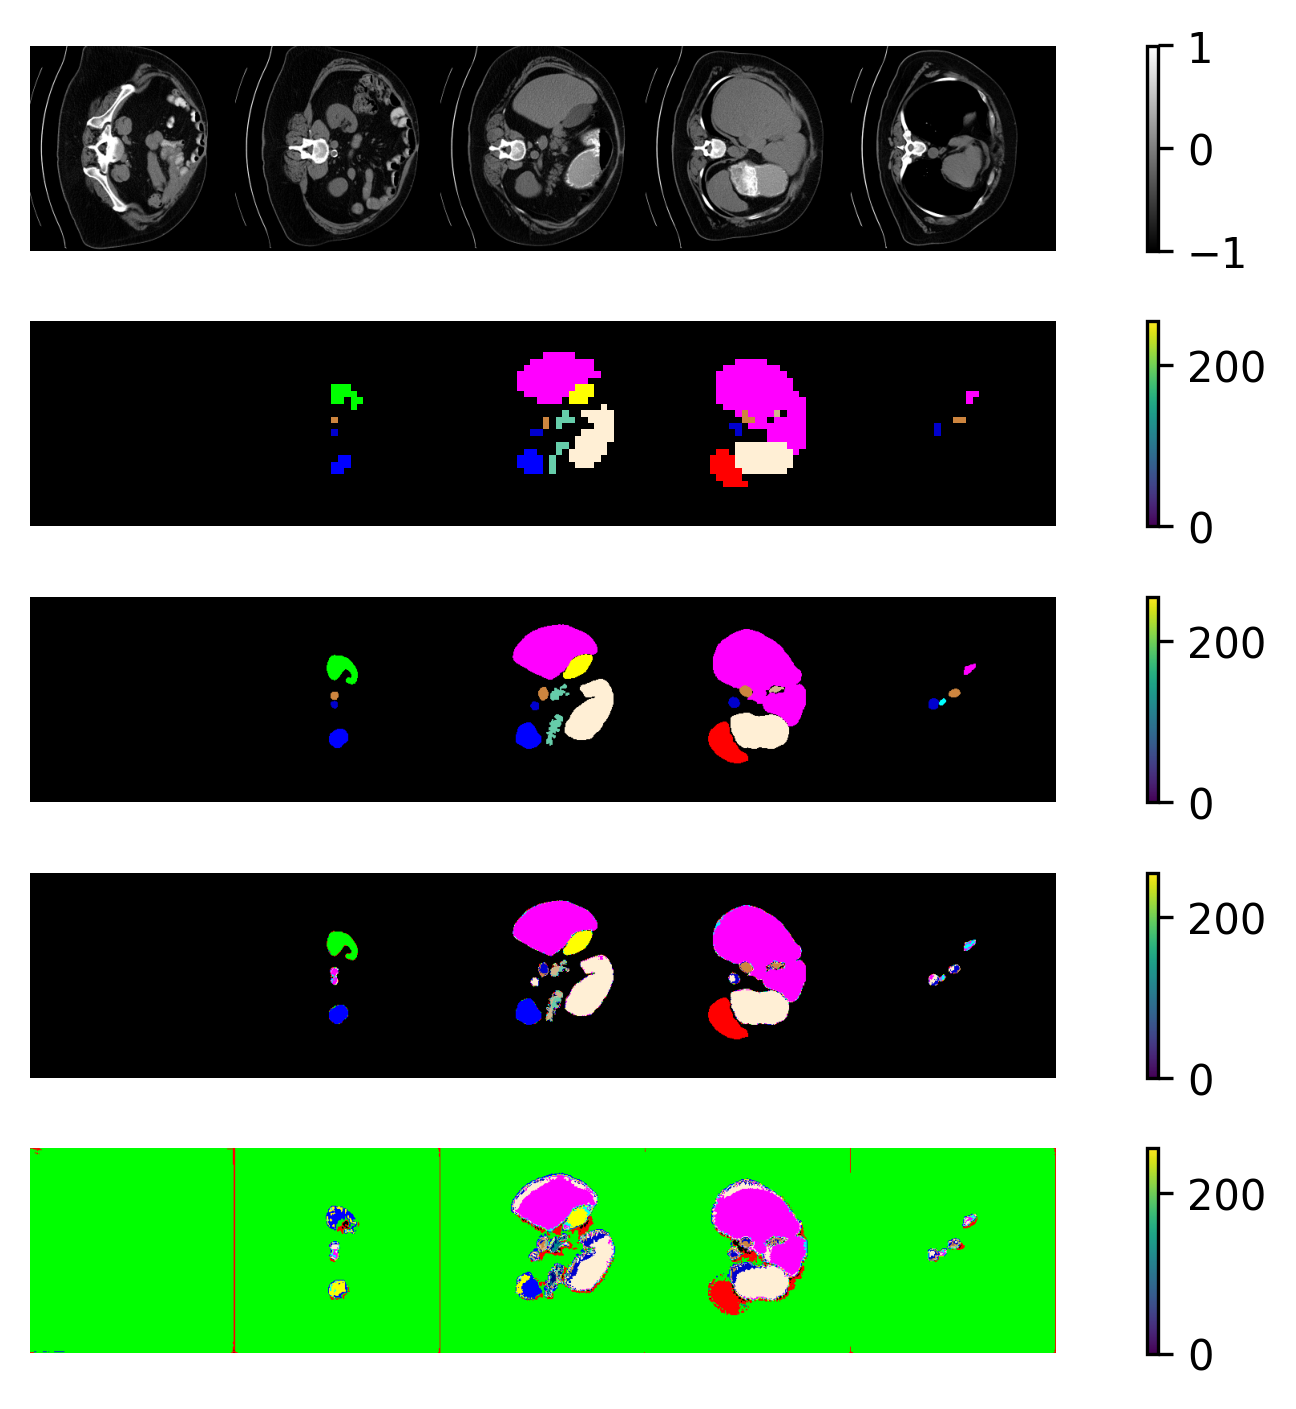

<Figure size 640x480 with 0 Axes>

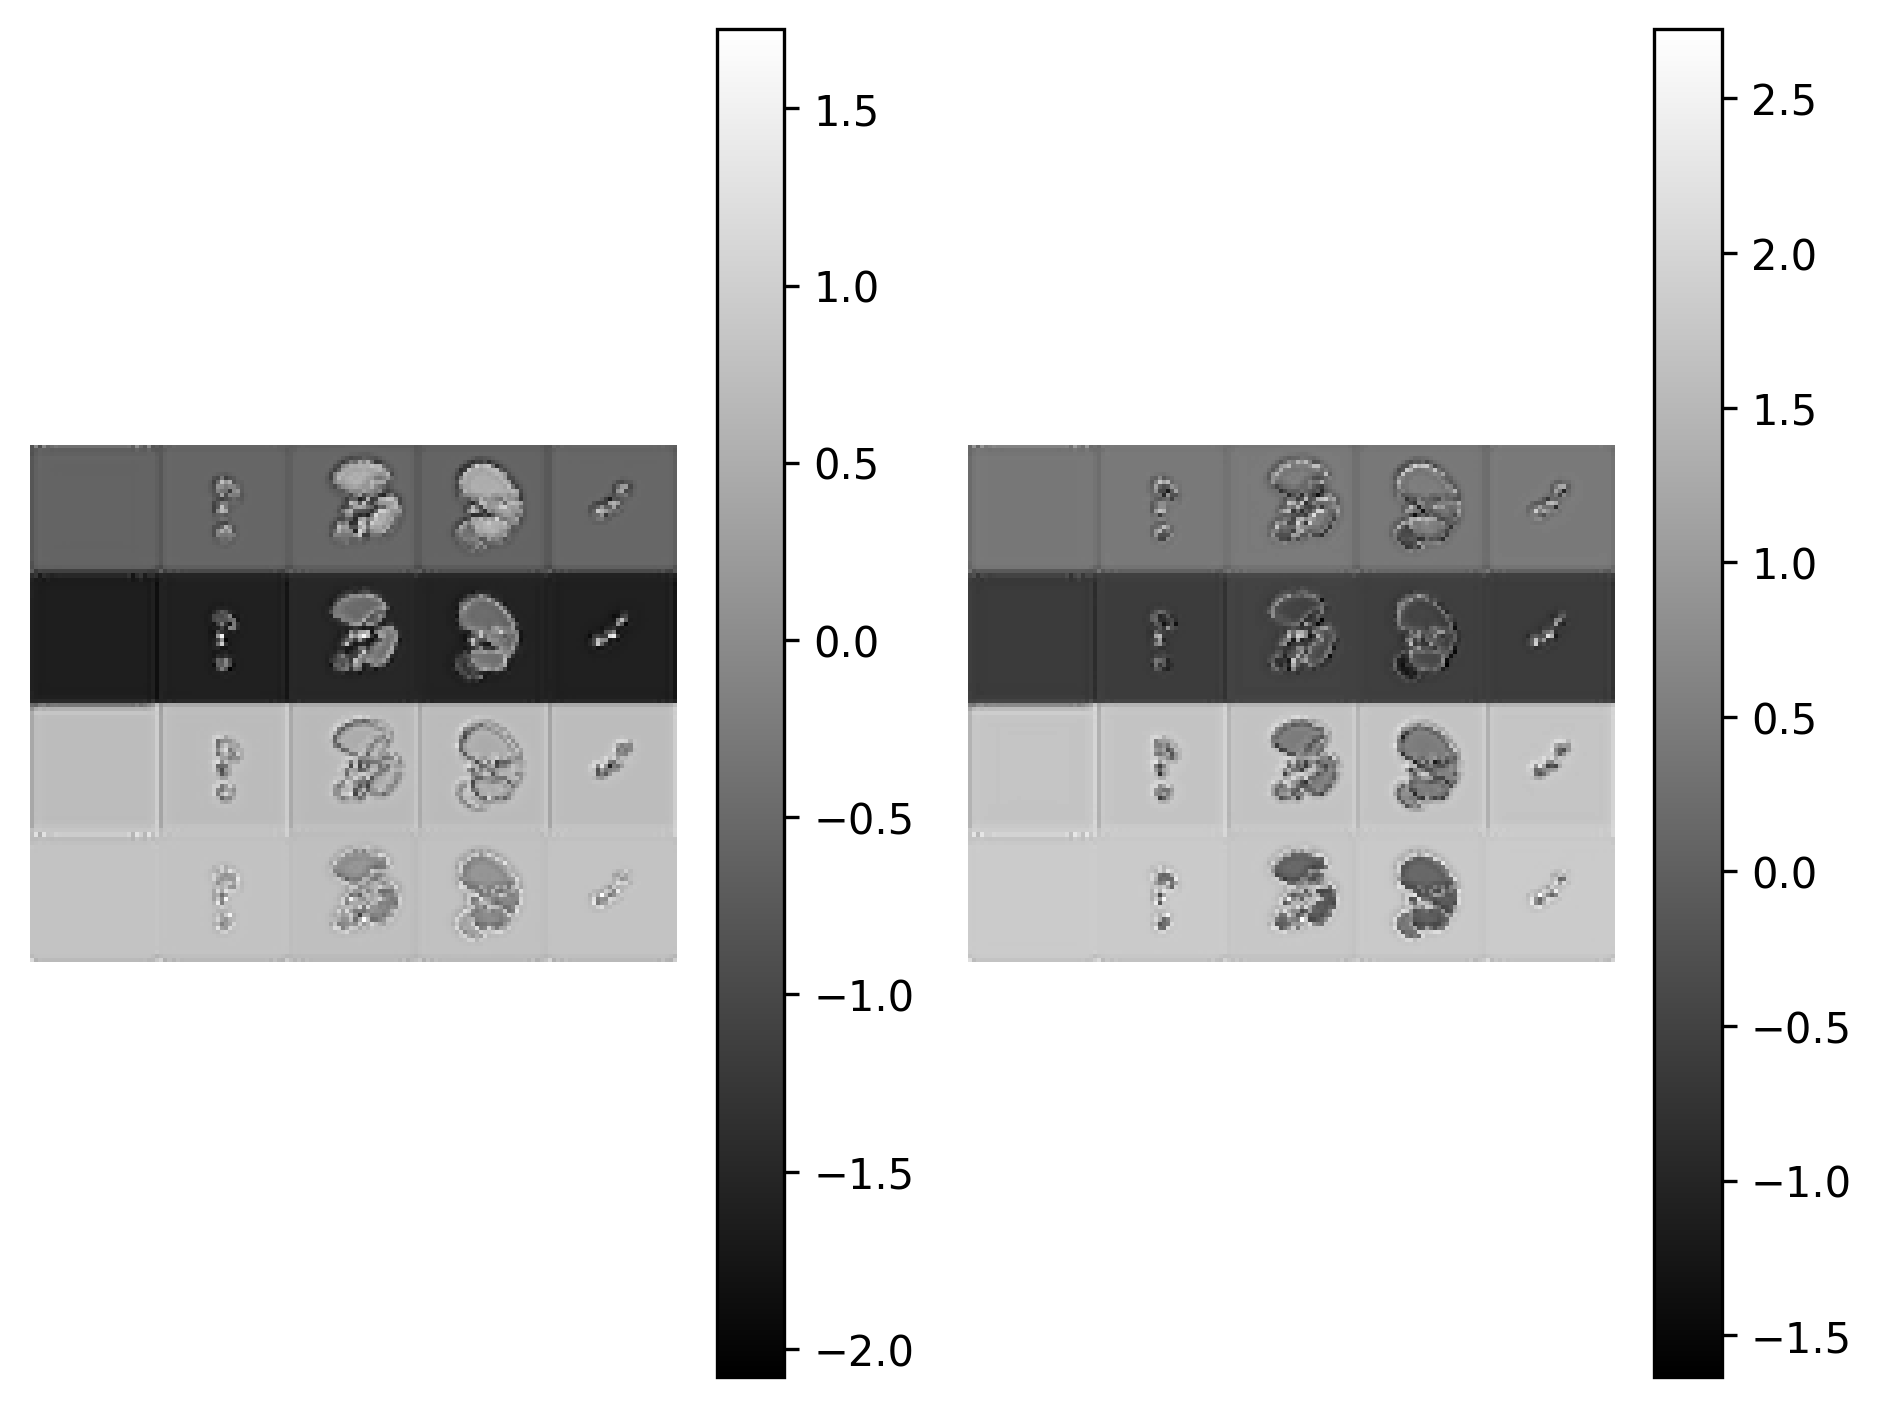

<Figure size 640x480 with 0 Axes>

In [143]:
for prompts in data:
    image, segmentation = prompts["image"], prompts["segmentation"]
    image_samples = image[0, :, :, 30::12]  # H W C
    image_samples = cv2.resize(np.ascontiguousarray(image_samples), 
                               (256, 256), interpolation=cv2.INTER_LINEAR)
    # image_samples = zoom(image_samples, (256, 256, image_samples.shape[2]), order=2)
    segmentation_samples = segmentation[0, :, :, 30::12]    # H W C
    # segmentation_samples = zoom(segmentation_samples, (256, 256, image_samples.shape[2]), order=1)
    segmentation_samples = cv2.resize(np.ascontiguousarray(segmentation_samples), 
                                      (256, 256), interpolation=cv2.INTER_NEAREST)
    segmentation_mini = F.interpolate(
        torch.tensor(segmentation_samples).unsqueeze(0).permute(0, 3, 1, 2), 
        size=(32, 32), mode="nearest")  # 1 1 H W
    break

# image_latent_list = list()
label_latent_list = list()
label_reconstruction_list = list()
label_latent_list2 = list()
label_reconstruction_list2 = list()
for idx in range(image_samples.shape[2]):
    """get data"""
    slice_image = image_samples[:, :, idx]      # H W
    slice_label_cls = segmentation_samples[:, :, idx]       # H W
    slice_label = (slice_label_cls/(model.num_classes-1)) * 2 - 1
    slice_label_mini = segmentation_mini[0, idx].unsqueeze(0).unsqueeze(0).float().cuda()

    # """get image latent"""
    # slice_image_tmp = torch.from_numpy(slice_image).unsqueeze(2).unsqueeze(0).repeat(
    #                         (1, 1, 1, 3)).float().cuda()
    # image_latent = model.get_learned_conditioning(prepare_for_first_stage(slice_image_tmp))
    # image_latent_list.append(rearrange(image_latent.permute(0, 2, 3, 1)[0].detach().cpu(), 'h w c -> (c h) w'))
    
    """ get label latent"""
    slice_label_tmp = np.expand_dims(slice_label, 2).repeat(3, axis=2)
    encoder_posterior = model.encode_first_stage(
                                    torch.tensor(slice_label_tmp).unsqueeze(0).permute((0, 3, 1, 2)).float().cuda()
                                )
    label_latent = model.get_first_stage_encoding(encoder_posterior).detach()
    label_latent_list.append(rearrange(label_latent.permute(0, 2, 3, 1)[0].detach().cpu(), 'h w c -> (c h) w'))

    """ get reconstructions """
    label_reconstruction = model.decode_first_stage(label_latent)
    label_reconstruction_tmp = torch.clamp(
        (label_reconstruction + 1.0) / 2.0, min=0.0, max=1.0
    )  # [-1, 1] -> [0, 1]     (b, c, h, w)
    label_reconstruction_tmp = torch.mean(label_reconstruction_tmp, dim=1, keepdim=False)    # b h w
    label_reconstruction_tmp *= (model.num_classes - 1)    # [0, 1] -> [0, num_classes - 1]
    label_reconstruction_tmp = np.rint(label_reconstruction_tmp[0].cpu().numpy())     # -> predicted label (H W)
    label_reconstruction_list.append(torch.tensor(label_reconstruction_tmp))

    """ modify label latent"""

    def modify(label_latent, slice_label_mini):
        return label_latent + (slice_label_mini==0)
    def distribution(label_latent, slice_label_mini):
        fig, axes = plt.subplots(nrows=model.num_classes-1, ncols=1, sharex=True)
        for idx in range(model.num_classes-1):
            axes[idx].hist((label_latent * (slice_label_mini == idx+1)).cpu().flatten(), bins=100)
            # axes[idx].set_xticks([])
            axes[idx].set_yticks([])
            axes[idx].set_ylabel(str(idx+1))
            # axes[idx].axis("off")
        plt.show()
        plt.clf()
    print(set(slice_label_cls.flatten()))
    # distribution(label_latent, slice_label_mini)
    label_latent2 = modify(label_latent, slice_label_mini)
    label_latent_list2.append(rearrange(label_latent2.permute(0, 2, 3, 1)[0].detach().cpu(), 'h w c -> (c h) w'))

    """ get modified reconstructions"""
    label_reconstruction2 = model.decode_first_stage(label_latent2)
    label_reconstruction_tmp = torch.clamp(
        (label_reconstruction2 + 1.0) / 2.0, min=0.0, max=1.0
    )  # [-1, 1] -> [0, 1]     (b, c, h, w)
    label_reconstruction_tmp = torch.mean(label_reconstruction_tmp, dim=1, keepdim=False)    # b h w
    label_reconstruction_tmp *= (model.num_classes - 1)    # [0, 1] -> [0, num_classes - 1]
    label_reconstruction_tmp = np.rint(label_reconstruction_tmp[0].cpu().numpy())     # -> predicted label (H W)
    label_reconstruction_list2.append(torch.tensor(label_reconstruction_tmp))

    


plt.figure(dpi=300)
plt.subplot(511)
plt.imshow(rearrange(image_samples, 'h w c -> h (c w)'), cmap="gray")
plt.axis("off")
plt.colorbar()
plt.subplot(512)
# rearrange(segmentation_mini.permute(0, 2, 3, 1)[0], 'h w c -> h (c w)')
plt.imshow(colorize(np.expand_dims(rearrange(segmentation_mini.permute(0, 2, 3, 1)[0], 'h w c -> h (c w)').numpy(), axis=2).repeat(3, axis=2)).astype(int))
plt.axis("off")
plt.colorbar()
plt.subplot(513)
# rearrange(segmentation_samples, 'h w c -> h (c w)')
plt.imshow(colorize(np.expand_dims(rearrange(segmentation_samples, 'h w c -> h (c w)'), axis=2).repeat(3, axis=2)).astype(int))
plt.axis("off")
plt.colorbar()
plt.subplot(514)
# torch.concat(label_reconstruction_list, dim=1)
plt.imshow(colorize(np.expand_dims(torch.concat(label_reconstruction_list, dim=1).numpy(), axis=2).repeat(3, axis=2)).astype(int))
plt.axis("off")
plt.colorbar()
plt.subplot(515)
# torch.concat(label_reconstruction_list, dim=1)
plt.imshow(colorize(np.expand_dims(torch.concat(label_reconstruction_list2, dim=1).numpy(), axis=2).repeat(3, axis=2)).astype(int))
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()
plt.clf()


plt.figure(dpi=300)
plt.subplot(121)
plt.imshow(torch.concat(label_latent_list, dim=1), cmap="gray")
plt.axis("off")
plt.colorbar()
plt.subplot(122)
plt.imshow(torch.concat(label_latent_list2, dim=1), cmap="gray")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()
plt.clf()
